# pronóstico de series de tiempo

En esta notebook vamos a realizar el pronóstico de una serie de tiempo
1. Descargaremos los datos
2. Graficaremos la series para darnos una idea de su comportamiento
3. realizaremos una prueba de raíz unitaria para comprobrar si la serie es estacionaria
4. Diferenciaremos la serie en caso de que no sea estacionaria
5. Realizamos la prueba a la serie diferenciada para ver si es estacionaria
6. Graficaremos la serie estacionaria
7. realizaremos su ACF y PACF para tratar de identificar que tipo de proceso es MA(q), AR(P), ARMA(p,q), etc
8. Estimamos distintos modelos
9. Elegimos el modelo
10. Realizamos el pronóstico 

In [ ]:
# como siempre comenzamos importando las librerias
import numpy as np
import pandas as pd 
import yfinance as yf
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA


%matplotlib inline

In [ ]:
#fijamos tamaño de graficas
plt.rcParams['figure.figsize'] = [10, 7.5]

## 1. Importamos los datos desde la api de yahoo finance

en mi caso yo voy a utilizar las acciones de walmart de México y voy a utilizar la información de los ultimos dos años hasta el día viernes, que es cuando estuvo abierta la bolsa

In [ ]:

elektra = yf.download('ELEKTRA.MX', 
                       start='2020-03-12', 
                       end='2022-03-12',
                       progress=False)

In [ ]:
#vemos los ultimos 10 datos
elektra.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-28,1354.000000,1354.050049,1323.390015,1343.709961,1343.709961,49010
2022-03-01,1328.000000,1343.699951,1305.199951,1324.959961,1324.959961,69579
2022-03-02,1339.689941,1342.000000,1305.010010,1335.780029,1335.780029,59033
2022-03-03,1340.000000,1340.000000,1311.699951,1323.219971,1323.219971,44697
2022-03-04,1330.739990,1336.989990,1312.030029,1326.550049,1326.550049,20892
2022-03-07,1337.000000,1337.000000,1309.010010,1317.099976,1317.099976,20204
2022-03-08,1329.979980,1329.979980,1286.510010,1298.530029,1298.530029,90740
2022-03-09,1295.000000,1308.989990,1270.000000,1282.089966,1282.089966,69865
2022-03-10,1298.849976,1312.949951,1261.500000,1287.979980,1287.979980,58951


In [ ]:
##Voy renombar columna 'Adj Close' por adj_close 
elektra.rename(columns = {'Adj Close':'adj_close'}, inplace=True)

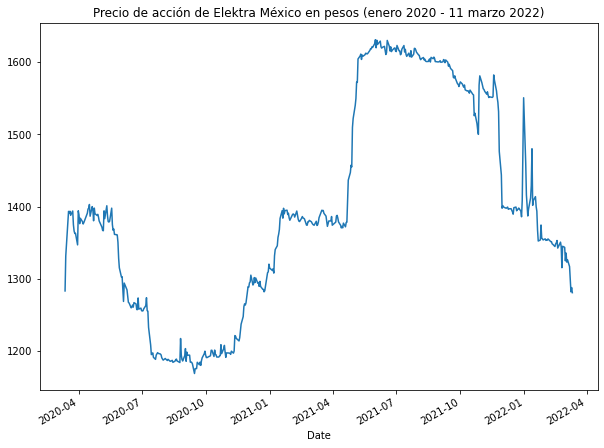

In [ ]:
# vamos a graficar
elektra.adj_close.plot()
plt.title('Precio de acción de Elektra México en pesos (enero 2020 - 11 marzo 2022)')
plt.show()

In [ ]:
#hacemos la prueba de dickey fuller aumentada ADF
adf = adfuller(elektra['adj_close'])

#presentamos el p-value
print('p-value: %f' % adf[1])



p-value: 0.759693


Recuerda que $H_0$: serie no estacionaria

In [ ]:
if adf[1] < 0.05:
    
    print(f'con un un p-value={adf[1].round(3)}\n Se rechaza hipótesis nula, serie estacionaria') 
    
else:
    
    print(f'con un un p-value = {adf[1].round(3)}\n NO se rechaza hipótesis nula, serie no estacionaria') 


con un un p-value = 0.76
 NO se rechaza hipótesis nula, serie no estacionaria


para hacer la serie estacionaria, usaremos lafunción shift de pandas 

y guardaremos la serie diferenciada en un objeto aparte

In [ ]:
elektra_diff = elektra['adj_close'] - elektra['adj_close'].shift()

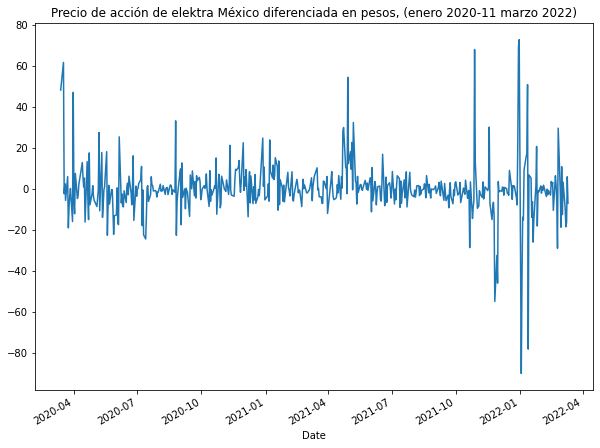

In [ ]:
#graficamos el tipo de cambio diferenciado
elektra_diff.plot()
plt.title('Precio de acción de elektra México diferenciada en pesos, (enero 2020-11 marzo 2022)')
plt.show()

In [ ]:
#eliminamos los Nan
elektra_diff = elektra_diff.dropna()

In [ ]:
## como la serie tiene saltos (los fines de semana los mercados no abren)
## removeremos la fecha
elektra_diff = elektra_diff.reset_index()

### eliminamos columna fecha
elektra_diff = elektra_diff.drop(['Date'], axis=1)

In [ ]:
elektra_diff

,adj_close
0,48.291504
1,61.796631
2,-2.343628
3,2.522339
4,-5.620605
...,...
499,-9.450073
500,-18.569946
501,-16.440063
502,5.890015


volvemos a realizar la prueba de raíz unitaria ADF

In [ ]:
adf1 = adfuller(elektra_diff)
if adf1[1] < 0.05:
    
    print(f'con un un p-value={adf1[1]}\n Se rechaza hipótesis nula, serie estacionaria') 
    
else:
    
    print(f'con un un p-value = {adf1[1]}\n NO se rechaza hipótesis nula, serie no estacionaria') 


con un un p-value=0.0
 Se rechaza hipótesis nula, serie estacionaria


Ahora que la serie ya es estacionaria, podemos hacer pronósticos con ella
por tanto debemos identificar que tipo de proceso es


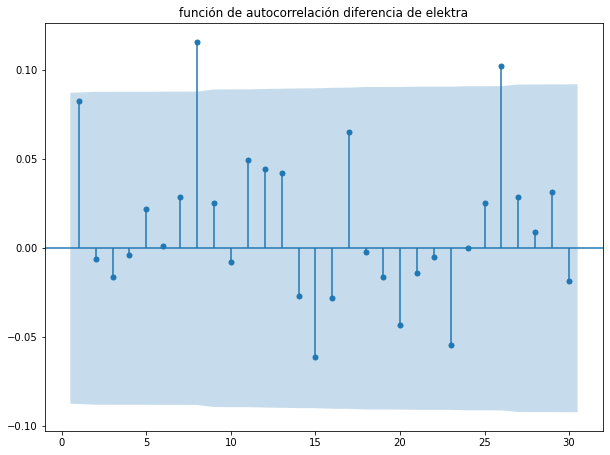

In [ ]:
#grafica de autocorrelación ACF
plot_acf(elektra_diff, zero=False, lags=30)
plt.title('función de autocorrelación diferencia de elektra')
plt.show()

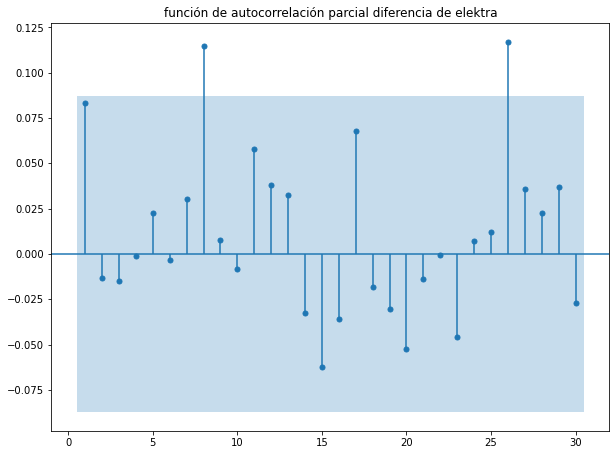

In [ ]:
#grafica de autocorrelación parcial PACF
plot_pacf(elektra_diff, zero=False, lags=30)
plt.title('función de autocorrelación parcial diferencia de elektra')
plt.show()

nota que el primer rezago de ACF y PACF es significativo, por lo que parece que la diferencia de las acciones de Elektra es en ARMA (2,2) 

In [ ]:
# estimamos un ARMA (2,2)
modelo = ARIMA(elektra_diff, order=(2, 0, 2))
resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  504
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2011.985
Date:                Sun, 13 Mar 2022   AIC                           4035.970
Time:                        17:59:44   BIC                           4061.305
Sample:                             0   HQIC                          4045.908
                                - 504                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.673     -0.003      0.997      -1.320       1.316
ar.L1         -0.3878      0.216     -1.798      0.072      -0.810       0.035
ar.L2         -0.7164      0.126     -5.689      0.000      -0.963      -0.470
ma.L1          0.4574      0.210      2.176      0.030       0.045       0.869
ma.L2          0.7442      0.116      6.413      0.000       0.517       0.972
sigma2       171.7876      4.552     37.739      0.000     162.866     180.709
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              3836.80
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Note que la constante no es significativa, es decir, es cero. Pero los coeficientes de los rezagos si son significativos (distintos de cero) acuerdo con sus p-values

Aunque los ACF y PACF nos sugieren un ARMA(1,1), no son del todo precisos, asi que vamos a estimar varios modelos con 6 rezagos de AR, 6rezagos de MA y elegir uno de acuerdo con el BIC (criterio bayesiano de información)

In [71]:
ic = {}
for ar in range(7):
    for ma in range(7):
        print(f"AR: {ar}, MA: {ma}")
        modelo = ARIMA(elektra_diff, order=(ar, 0, ma))
        resultado = modelo.fit()
        ic[(ar, ma)] = [resultado.aic, resultado.bic]

ic = pd.DataFrame(ic, index=["AIC", "BIC"]).T
ic.index = ic.index.set_names(["AR", "MA"])
ic

AR: 0, MA: 0
AR: 0, MA: 1
AR: 0, MA: 2
AR: 0, MA: 3
AR: 0, MA: 4
AR: 0, MA: 5
AR: 0, MA: 6
AR: 1, MA: 0
AR: 1, MA: 1
AR: 1, MA: 2
AR: 1, MA: 3
AR: 1, MA: 4
AR: 1, MA: 5
AR: 1, MA: 6
AR: 2, MA: 0
AR: 2, MA: 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 2, MA: 2
AR: 2, MA: 3
AR: 2, MA: 4


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 5


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 2, MA: 6


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 0
AR: 3, MA: 1
AR: 3, MA: 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 3


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 4


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 5


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 6


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 0
AR: 4, MA: 1
AR: 4, MA: 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 3


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 4


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 5


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 6


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 0
AR: 5, MA: 1
AR: 5, MA: 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 3


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 4


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 5


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 6


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 0
AR: 6, MA: 1
AR: 6, MA: 2


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 3


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 4


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 5


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 6


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC          BIC
AR MA                          
0  0   4032.881634  4041.326787
   1   4031.269984  4043.937713
   2   4033.269341  4050.159646
   3   4035.147923  4056.260805
   4   4037.121516  4062.456974
   5   4038.720745  4068.278779
   6   4040.720568  4074.501178
1  0   4031.312872  4043.980601
   1   4033.269612  4050.159917
   2   4035.252352  4056.365233
   3   4037.141176  4062.476634
   4   4036.982733  4066.540766
   5   4037.959151  4071.739761
   6   4039.717185  4077.720371
2  0   4033.253113  4050.143418
   1   4035.210427  4056.323309
   2   4035.970040  4061.305498
   3   4039.102510  4068.660544
   4   4037.109999  4070.890609
   5   4035.452738  4073.455924
   6   4037.591703  4079.817465
3  0   4035.131172  4056.244054
   1   4037.132799  4062.468257
   2   4033.702691  4063.260725
   3   4036.673468  4070.454078
   4   4039.900099  4077.903286
   5   4039.999565  4082.225327
   6   4041.166158  4087.614497
4  0   4037.130134  4062.465592
   1   4039.086677  4068.644711
   2   4036.163226  4069.943836
   3   4038.292272  4076.295458
   4   4040.623207  4082.848970
   5   4040.752877  4087.201216
   6   4037.367903  4088.038819
5  0   4038.865698  4068.423732
   1   4040.862776  4074.643386
   2   4040.837584  4078.840770
   3   4039.535834  4081.761597
   4   4040.184242  4086.632581
   5   4040.811334  4091.482249
   6   4045.932056  4100.825547
6  0   4040.863339  4074.643950
   1   4042.860284  4080.863471
   2   4042.414727  4084.640490
   3   4040.861302  4087.309641
   4   4042.302990  4092.973905
   5   4042.771694  4097.665186
   6   4047.293236  4106.409303

los ordenamos de acuerdo al BIC que es el indicador que voy a utilizar

In [72]:
ic.sort_values('BIC', ascending = True)

AIC          BIC
AR MA                          
0  0   4032.881634  4041.326787
   1   4031.269984  4043.937713
1  0   4031.312872  4043.980601
2  0   4033.253113  4050.143418
0  2   4033.269341  4050.159646
1  1   4033.269612  4050.159917
3  0   4035.131172  4056.244054
0  3   4035.147923  4056.260805
2  1   4035.210427  4056.323309
1  2   4035.252352  4056.365233
2  2   4035.970040  4061.305498
0  4   4037.121516  4062.456974
4  0   4037.130134  4062.465592
3  1   4037.132799  4062.468257
1  3   4037.141176  4062.476634
3  2   4033.702691  4063.260725
1  4   4036.982733  4066.540766
0  5   4038.720745  4068.278779
5  0   4038.865698  4068.423732
4  1   4039.086677  4068.644711
2  3   4039.102510  4068.660544
4  2   4036.163226  4069.943836
3  3   4036.673468  4070.454078
2  4   4037.109999  4070.890609
1  5   4037.959151  4071.739761
2  5   4035.452738  4073.455924
0  6   4040.720568  4074.501178
5  1   4040.862776  4074.643386
6  0   4040.863339  4074.643950
4  3   4038.292272  4076.295458
1  6   4039.717185  4077.720371
3  4   4039.900099  4077.903286
5  2   4040.837584  4078.840770
2  6   4037.591703  4079.817465
6  1   4042.860284  4080.863471
5  3   4039.535834  4081.761597
3  5   4039.999565  4082.225327
4  4   4040.623207  4082.848970
6  2   4042.414727  4084.640490
5  4   4040.184242  4086.632581
4  5   4040.752877  4087.201216
6  3   4040.861302  4087.309641
3  6   4041.166158  4087.614497
4  6   4037.367903  4088.038819
5  5   4040.811334  4091.482249
6  4   4042.302990  4092.973905
   5   4042.771694  4097.665186
5  6   4045.932056  4100.825547
6  6   4047.293236  4106.409303

el BIC me sugiere un ARMA(1,1)

veamos que me sugiere el criterio de Akaike (AIC)

In [73]:
ic.sort_values('AIC', ascending = True)

AIC          BIC
AR MA                          
0  1   4031.269984  4043.937713
1  0   4031.312872  4043.980601
0  0   4032.881634  4041.326787
2  0   4033.253113  4050.143418
0  2   4033.269341  4050.159646
1  1   4033.269612  4050.159917
3  2   4033.702691  4063.260725
   0   4035.131172  4056.244054
0  3   4035.147923  4056.260805
2  1   4035.210427  4056.323309
1  2   4035.252352  4056.365233
2  5   4035.452738  4073.455924
   2   4035.970040  4061.305498
4  2   4036.163226  4069.943836
3  3   4036.673468  4070.454078
1  4   4036.982733  4066.540766
2  4   4037.109999  4070.890609
0  4   4037.121516  4062.456974
4  0   4037.130134  4062.465592
3  1   4037.132799  4062.468257
1  3   4037.141176  4062.476634
4  6   4037.367903  4088.038819
2  6   4037.591703  4079.817465
1  5   4037.959151  4071.739761
4  3   4038.292272  4076.295458
0  5   4038.720745  4068.278779
5  0   4038.865698  4068.423732
4  1   4039.086677  4068.644711
2  3   4039.102510  4068.660544
5  3   4039.535834  4081.761597
1  6   4039.717185  4077.720371
3  4   4039.900099  4077.903286
   5   4039.999565  4082.225327
5  4   4040.184242  4086.632581
4  4   4040.623207  4082.848970
0  6   4040.720568  4074.501178
4  5   4040.752877  4087.201216
5  5   4040.811334  4091.482249
   2   4040.837584  4078.840770
6  3   4040.861302  4087.309641
5  1   4040.862776  4074.643386
6  0   4040.863339  4074.643950
3  6   4041.166158  4087.614497
6  4   4042.302990  4092.973905
   2   4042.414727  4084.640490
   5   4042.771694  4097.665186
   1   4042.860284  4080.863471
5  6   4045.932056  4100.825547
6  6   4047.293236  4106.409303

criterio de AIC tambien me sugiere ARMA (1,1)

In [74]:
# estimamos un ARMA (0,1)
modelo = ARIMA(elektra_diff, order=(0, 0, 1))
resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  504
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2012.635
Date:                Sun, 13 Mar 2022   AIC                           4031.270
Time:                        18:00:23   BIC                           4043.938
Sample:                             0   HQIC                          4036.239
                                - 504                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.690     -0.002      0.998      -1.353       1.350
ma.L1          0.0858      0.019      4.572      0.000       0.049       0.123
sigma2       172.2180      3.922     43.910      0.000     164.531     179.905
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4388.52
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

En realidad, en este caso, como diferenciamos una vez la serie de tiempo estacionaria para hacerla estacionaria, nuestro modelo ARMA (1,1), es un ARIMA(1,1,1) de la serie original

In [83]:
# estimamos un ARIMA (0,1)
modelo2 = ARIMA(elektra['adj_close'], order=(1, 1, 0))
resultado2 = modelo2.fit()
resultado2.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  505
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2012.651
Date:                Sun, 13 Mar 2022   AIC                           4029.302
Time:                        18:01:13   BIC                           4037.747
Sample:                             0   HQIC                          4032.615
                                - 505                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0852      0.016      5.277      0.000       0.054       0.117
sigma2       172.2317      3.935     43.773      0.000     164.520     179.943
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4452.96
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.23   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
# vamos a estimar la serie con el modelo ARIMA
elektra['pronostico'] = resultado2.predict()
elektra['pronostico'][0] = elektra['adj_close'][0]

C:\Users\alda1\AppData\Local\Temp/ipykernel_9128/224709543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elektra['pronostico'][0] = elektra['adj_close'][0]


graficamos la y_estimada con la y_original

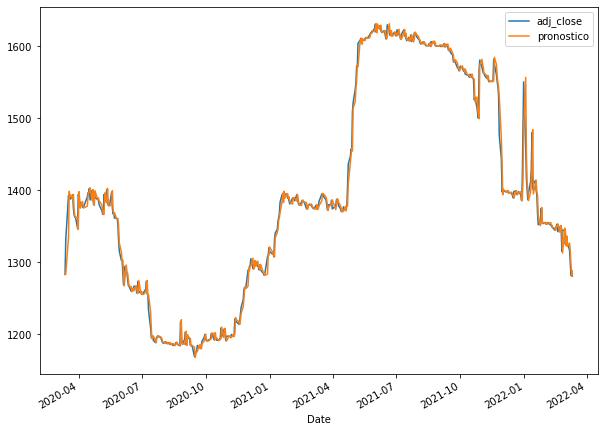

In [85]:
elektra[['adj_close', 'pronostico']].plot()
plt.show()

In [86]:
#calculamos cuantas observaciones tenemos para hacer nuestra predicción
len(elektra)


505

la función len nos arrojo que tenemos 554 observaciones,  quiere decir que el lunes sería la observación 555, el martes la 556, y el miércoles la 557

In [87]:
## vamos a pronosticar esos días
resultado2.predict(506, 509)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


506    1280.278143
507    1280.273781
508    1280.273409
509    1280.273378
Name: predicted_mean, dtype: float64

mi pronostico para el lunes 14 de marzo es que la acción de walmart tenga un precio de cierre (ajustado) de 75.912163

El viernes cerro en 78.7399